In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
from pyBioInfo.IO.File import GtfFile, GtfGeneBuilder

# Make info.tsv

In [2]:
f_gtf = "results/assembly/asm.final.sorted.gtf.gz"
f_ngs_tsv = "results/function/eggnog/ngs.emapper.annotations"
f_tgs_tsv = "results/function/eggnog/tgs.emapper.annotations"
f_out = "results/function/info.tsv"

In [3]:
with GtfFile(f_gtf) as f:
    records = [r for r in f]
genes = [g for g in GtfGeneBuilder(records)]

In [4]:
def load_eggnog_annotation(path):
    with open(path) as f:
        for line in f:
            if line.startswith("#query"):
                header = line[1:-1].split("\t")
                break
    anno = pd.read_csv(path, sep="\t", header=None, comment="#")
    anno.columns = header
    anno["isoform"] = [q.split("_")[1].split(":")[0] for q in anno["query"]]
    array = []
    for isoform, tmp in anno.groupby(by="isoform"):
        row = tmp.sort_values(by="evalue").iloc[0]
        array.append(row)
    tmp = pd.DataFrame(array)
    return tmp

anno1 = load_eggnog_annotation(f_ngs_tsv)
anno2 = load_eggnog_annotation(f_tgs_tsv)
print(len(anno1), len(anno2))

anno = pd.concat([anno1, anno2])
anno.index = [i for i in range(len(anno))]
anno.index.name = None

74245 127421


In [5]:
rows = []
for g in genes:
    for t in g.transcripts:
        record = t.records["exon"][0]
        gid = record.attributes["gene_id"]
        tid = record.attributes["transcript_id"]
        row = [gid, tid]
        rows.append(row)
dat = pd.DataFrame(rows, columns=["gene", "isoform"])

In [6]:
info = dat.merge(anno, left_on="isoform", right_on="isoform", how="left")

In [7]:
info.to_csv(f_out, sep="\t", index=False)

# Analysis of genotype, go term and kegg

In [9]:
info = pd.read_csv("results/function/info.tsv", sep="\t")

In [10]:
protein_coding_genes = []
for gene, tmp in info.groupby(by="gene"):
    if sum(~tmp["query"].isna()) > 0:
        protein_coding_genes.append(gene)

v1 = len(protein_coding_genes)
v2 = len(set(info["gene"])) - v1
print("protein coding:", v1, v1 / (v1 + v2))
print("ncRNA:", v2)

protein coding: 24801 0.7433684021221113
ncRNA: 8562


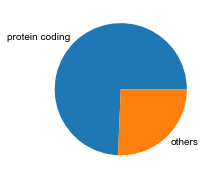

In [11]:
plt.figure(figsize=(3, 3))
plt.pie([v1, v2], labels=["protein coding", "others"])
plt.tight_layout()
plt.savefig("figures/protein_coding.pie.pdf", dpi=300)

In [12]:
gene_go_terms = dict()
for gene, tmp in info.groupby(by="gene"):
    tmp = tmp[~tmp["query"].isna()]
    vs = []
    for gos in tmp["GOs"]:
        for go in gos.split(","):
            if go.startswith("GO:"):
                vs.append(go)
    vs = set(vs)
    gene_go_terms[gene]  = vs
    
n = 0
for k, v in gene_go_terms.items():
    if len(v) > 0:
        n += 1
print("Total genes:", len(gene_go_terms))
print("GO term genes:", n, n / v1)

Total genes: 33363
GO term genes: 16902 0.6815047780331438


In [13]:
gene_keggs = dict()
for gene, tmp in info.groupby(by="gene"):
    tmp = tmp[~tmp["query"].isna()]
    vs = []
    for ks in tmp["KEGG_Pathway"]:
        for k in ks.split(","):
            if k != "-":
                vs.append(k)
    vs = set(vs)
    gene_keggs[gene]  = vs
    
n = 0
for k, v in gene_keggs.items():
    if len(v) > 0:
        n += 1
print("Total genes:", len(gene_keggs))
print("KEGG genes:", n, n / v1)

Total genes: 33363
KEGG genes: 10366 0.4179670174589734


In [14]:
list1 = set()
list2 = set()
list3 = set()
for g in info["gene"]:
    if g in protein_coding_genes:
        list1.add(g)
    if len(gene_go_terms[g]) > 0:
        list2.add(g)
    if len(gene_keggs[g]) > 0:
        list3.add(g)

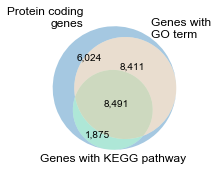

In [15]:
plt.figure(figsize=(3.5, 2.5))
ret = venn3([list1, list2, list3], 
    set_labels=["Protein coding\ngenes", "Genes with\nGO term", "Genes with KEGG pathway"], 
    set_colors=["C0", "C1", "C2"])
for item in ret.subset_labels:
    if item is None:
        continue
    item.set_text(format(int(item.get_text()), ","))
plt.tight_layout()
plt.show()

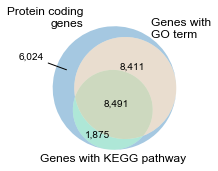

In [41]:
plt.figure(figsize=(3.5, 2.5))
ret = venn3([list1, list2, list3], 
    set_labels=["Protein coding\ngenes", "Genes with\nGO term", "Genes with KEGG pathway"], 
    set_colors=["C0", "C1", "C2"])
for item in ret.subset_labels:
    if item is None:
        continue
    item.set_text(format(int(item.get_text()), ","))
    # item.set_text(None)

    
ret.subset_labels[0].set_text(None)
ax = plt.gca()
ax.annotate('6,024', xy=(-0.45, 0.2), xytext=(-0.9, 0.3), arrowprops=dict(facecolor='black', arrowstyle="-"),)


plt.tight_layout()
plt.savefig("figures/function_annotation.pdf", dpi=300)

## GO term

In [42]:
lines = []
with open("../common/goterm/go-basic.obo") as f:
    for line in f:
        lines.append(line.strip("\n"))
        
terms = []
i = 0
while i < len(lines) :
    line = lines[i]
    if line == "[Term]":
        term = defaultdict(list)
        j = i + 1
        while True:
            line1 = lines[j]
            if line1 == "":
                i = j + 1
                terms.append(term)
                break
            else:
                k = line1.find(":")
                term[line1[:k]].append(line1[k+2:])
            j += 1
    else:
        i += 1
        
term_dict = dict()
for term in terms:
    vs1 = term["id"]
    vs2 = term["alt_id"]
    for v in vs1:
        assert v not in term_dict
        term_dict[v] = term
    for v in vs2:
        assert v not in term_dict
        term_dict[v] = term

len(term_dict)

50653

In [43]:
s1 = set()
s2 = set()
s3 = set()
for g, gos in gene_go_terms.items():
    if len(gos) == 0:
        continue
    terms = [term_dict[go] for go in gos]
    namespaces = set()
    biological_process = False
    cellular_component = False
    molecular_function = False
    for t in terms:
        namespaces.add(t["namespace"][0])
    if "biological_process" in namespaces:
        s1.add(g)
    if "cellular_component" in namespaces:
        s2.add(g)
    if "molecular_function" in namespaces:
        s3.add(g)

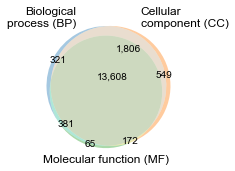

In [44]:
plt.figure(figsize=(3.5, 2.5))
ret = venn3([s1, s2, s3], 
      set_labels=["Biological\nprocess (BP)", "Cellular\ncomponent (CC)", "Molecular function (MF)"], 
      set_colors=["C0", "C1", "C2"])
for item in ret.subset_labels:
    if item is None:
        continue
    item.set_text(format(int(item.get_text()), ","))
plt.tight_layout()
plt.show()

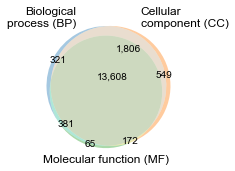

In [82]:
plt.figure(figsize=(3.5, 2.5))
ret = venn3([s1, s2, s3], 
      set_labels=["Biological\nprocess (BP)", "Cellular\ncomponent (CC)", "Molecular function (MF)"], 
      set_colors=["C0", "C1", "C2"])
for item in ret.subset_labels:
    if item is None:
        continue
    item.set_text(format(int(item.get_text()), ","))

if False:
    ret.subset_labels[0].set_text(None)
    ret.subset_labels[1].set_text(None)
    ret.subset_labels[2].set_text(None)
    ret.subset_labels[3].set_text(None)
    ret.subset_labels[4].set_text(None)
    ret.subset_labels[5].set_text(None)
    ax = plt.gca()
    ax.annotate('321', xy=(-0.49, 0.2), xytext=(-0.8, 0.3), arrowprops=dict(facecolor='black', arrowstyle="-"),)
    ax.annotate('1,806', xy=(0, 0.51), xytext=(-0.12, 0.7), arrowprops=dict(facecolor='black', arrowstyle="-"),)
    ax.annotate('549', xy=(0.54, 0.0), xytext=(0.7, 0), arrowprops=dict(facecolor='black', arrowstyle="-"),)

plt.tight_layout()
plt.show()
# plt.savefig("figures/goterm_types.pdf", dpi=300)

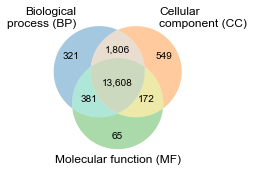

In [91]:
plt.figure(figsize=(3.5, 2.5))
ret = venn3([1, 1, 1, 1, 1, 1, 1], 
      set_labels=["Biological\nprocess (BP)", "Cellular\ncomponent (CC)", "Molecular function (MF)"], 
      set_colors=["C0", "C1", "C2"])

ret.subset_labels[0].set_text("321")
ret.subset_labels[1].set_text("549")
ret.subset_labels[2].set_text("1,806")
ret.subset_labels[3].set_text("65")
ret.subset_labels[4].set_text("381")
ret.subset_labels[5].set_text("172")
ret.subset_labels[6].set_text("13,608")

plt.tight_layout()
plt.savefig("figures/goterm_types.pdf", dpi=300)

In [93]:
rows = []
for g, gos in gene_go_terms.items():
    for go in gos:
        rows.append([go, g])
tmp = pd.DataFrame(rows)
tmp.to_csv("results/function/goterm/term2gene.tsv", sep="\t", header=False, index=False)

In [94]:
rows = []
for goid, term in term_dict.items():
    rows.append([goid, term["name"][0]])
tmp = pd.DataFrame(rows)
tmp.to_csv("results/function/goterm/term2name.tsv", sep="\t", index=False, header=False)